In [82]:
import pypsa
import pandas as pd
from matplotlib.pyplot import legend
import matplotlib.pyplot as plt
import numpy as np

### Read Network

In [83]:
# export
#n0 = 
# mar_es
#n1 = pypsa.Network('../../resources/mar_es_only/elec_s_4_ec_lc1.0_Co2L_144H_2030_0.071_DF_nosmr.nc')
n1 = pypsa.Network('../../resources/pypsaearthsec/emission_export/postnetworks/elec_s_4_ec_lc1.0__Co2L0.90-144H_2030_0.071_DF_0export.nc')
print("The network representing MAR ES only 'n1' has been imported")

# mar_es_export (140 TWh)
#n2 = pypsa.Network('../../resources/mar_es_export/elec_s_4_ec_lc1.0_Co2L_144H_2030_0.071_DF_nosmr.nc')
n2 = pypsa.Network('../../resources/pypsaearthsec/emission_export/postnetworks/elec_s_4_ec_lc1.0__Co2L0.90-144H_2030_0.071_DF_20export.nc')
print("The network representing MAR ES + Export 'n2' has been imported")

n3 = pypsa.Network('../../resources/export_only/elec_s_4_ec_lc1.0_Co2L_144H_2030_0.071_DF_solved.nc')
print("The network representing Export only 'n3' has been imported")


INFO:pypsa.io:Imported network elec_s_4_ec_lc1.0__Co2L0.90-144H_2030_0.071_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


The network representing MAR ES only 'n1' has been imported


INFO:pypsa.io:Imported network elec_s_4_ec_lc1.0__Co2L0.90-144H_2030_0.071_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


The network representing MAR ES + Export 'n2' has been imported


INFO:pypsa.io:Imported network elec_s_4_ec_lc1.0_Co2L_144H_2030_0.071_DF_solved.nc has buses, carriers, generators, links, loads, stores


The network representing Export only 'n3' has been imported


### Compare solar and wind generator capacities

In [84]:
# Maximum potential "p_nom_max" of each carrier in each network
for n in [n1, n2, n3]:
    for carrier in ['onwind', 'solar']: #for all generators use: n.generators.carrier.unique():
        print(f"p_nom_max of {carrier}: \t {n.generators[n.generators.carrier==carrier].p_nom_max.sum()/1e3:.2f} GW")

p_nom_max of onwind: 	 564.15 GW
p_nom_max of solar: 	 877.08 GW
p_nom_max of onwind: 	 564.15 GW
p_nom_max of solar: 	 877.08 GW
p_nom_max of onwind: 	 564.15 GW
p_nom_max of solar: 	 877.06 GW


In [85]:
# Optimised capacities "p_nom_opt" of each carrier in each network
for n in [n1, n2, n3]:
    for carrier in ['onwind', 'solar']: #for all generators use: n.generators.carrier.unique():
        print(f"p_nom_opt of {carrier}: \t {n.generators[n.generators.carrier==carrier].p_nom_opt.sum()/1e3:.2f} GW")

p_nom_opt of onwind: 	 1.40 GW
p_nom_opt of solar: 	 32.50 GW
p_nom_opt of onwind: 	 1.40 GW
p_nom_opt of solar: 	 50.22 GW
p_nom_opt of onwind: 	 1.40 GW
p_nom_opt of solar: 	 8.35 GW


In [86]:
# Exploitation of the potential of each carrier in each network
for n in [n1, n2, n3]:
    for carrier in ['onwind', 'solar']: #for all generators use: n.generators.carrier.unique():
        print(f"Exploitation of {carrier}: \t {(n.generators[n.generators.carrier==carrier].p_nom_opt.sum()/n.generators[n.generators.carrier==carrier].p_nom_max.sum())*1e2:.2f} %")

Exploitation of onwind: 	 0.25 %
Exploitation of solar: 	 3.71 %
Exploitation of onwind: 	 0.25 %
Exploitation of solar: 	 5.73 %
Exploitation of onwind: 	 0.25 %
Exploitation of solar: 	 0.95 %


### Compare all generator capacities

In [87]:
# Show all capacities
print("The installed generator capacities are:")
for n in [n1, n2, n3]:
    generator_capacities = n.generators.p_nom_opt.groupby(n.generators.carrier).sum()/1e3
    print(generator_capacities)
del n

The installed generator capacities are:
carrier
CCGT                                          1.272000
OCGT                                          0.344983
coal                                          1.702266
gas                                           0.010082
oil                                           1.737987
onwind                                        1.404995
residential rural solar thermal               0.001317
residential urban decentral solar thermal     0.000752
ror                                           0.479380
services rural solar thermal                  0.000741
services urban decentral solar thermal        0.000875
solar                                        32.497583
urban central solar thermal                   0.001223
Name: p_nom_opt, dtype: float64
carrier
CCGT                                          1.272000
OCGT                                          0.344984
coal                                          1.702266
gas                             

### Emissions

In [88]:
n1.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
lc_limit,transmission_expansion_cost_limit,"AC, DC",<=,4.817521e+08,NaN,0.0


### Total system cost and LCOH

In [89]:
cost_difference= (n2.objective-n1.objective) # in €

export_demand = n2.loads_t.p.loc[:, 'H2 export load'].sum() # in MWh
export_demand_weighted = export_demand*n2.snapshot_weightings.generators[0] # We need to multiply by the snapshot weightings to get the annualized value

n12_lcoh = cost_difference/(n2.loads_t.p.loc[:, 'H2 export load'].sum()*n2.snapshot_weightings.generators[0]) # Cost difference between systems divided by the export demand
n3_lcoh = n3.objective/(n3.loads_t.p.loc[:, 'H2 export load'].sum()*n3.snapshot_weightings.generators[0])

print(f"The following values relate to the comparison of the MAR ES only and the MAR ES + Export network:\n")
print(f"The total annualized system cost for Morocco is {n1.objective / 1e9:.2f} B€ without export and {n2.objective /1e9:.2f} B€ with export")
print(f"The export of {export_demand_weighted/1e3:.2f} GWh results in a cost difference of {cost_difference/ 1e9:.2f} B€")
print(f"Cost per unit hydrogen export: {n12_lcoh:.2f} €/MWh" )
print(f"\nThe following values relate to Export only network:\n")
print(f"The total annualized system cost for Export only is {n3.objective / 1e9:.2f} B€")

print(f"Cost per unit hydrogen export: {n3_lcoh:.2f} €/MWh" )

The following values relate to the comparison of the MAR ES only and the MAR ES + Export network:

The total annualized system cost for Morocco is 1.77 B€ without export and 2.85 B€ with export
The export of 20054.79 GWh results in a cost difference of 1.08 B€
Cost per unit hydrogen export: 53.83 €/MWh

The following values relate to Export only network:

The total annualized system cost for Export only is 0.53 B€
Cost per unit hydrogen export: 52.82 €/MWh


### Plotting

LCOH

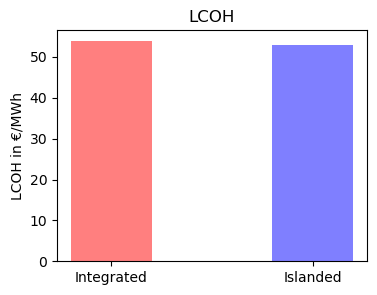

In [90]:
# Prepare data
n_names = ["Integrated", "Islanded"]
costs = [n12_lcoh, n3_lcoh]
y_pos = np.arange(len(n_names))
# Create bars and set the figure size
plt.figure(figsize=(4, 3))
plt.bar(y_pos, costs, width=0.4, align='center', alpha=0.5, color=['r', 'b'])

# Enhance graph
plt.xticks(y_pos, n_names)
plt.ylabel("LCOH in €/MWh")
plt.title("LCOH")

# Create graph and save it
plt.savefig("../../results/graphics/first_results/LCOH.pdf")
plt.show()

Total system cost

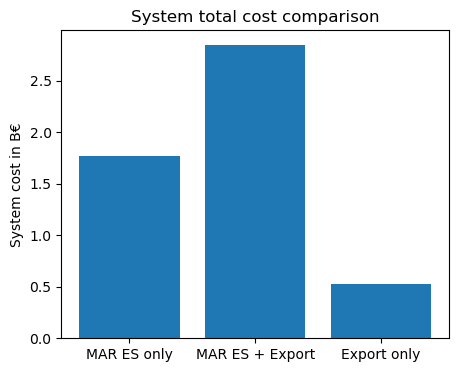

In [91]:
n_names = ["MAR ES only", "MAR ES + Export", "Export only"]
costs = [n1.objective/1e9, n2.objective/1e9, n3.objective/1e9]
y_pos = np.arange(len(n_names))
# Create bars
plt.figure(figsize=(5, 4))
plt.bar(y_pos, costs)

# Enhance graph
plt.xticks(y_pos, n_names)
plt.ylabel("System cost in B€")
plt.title("System total cost comparison")

# Create graph and save it
plt.show()

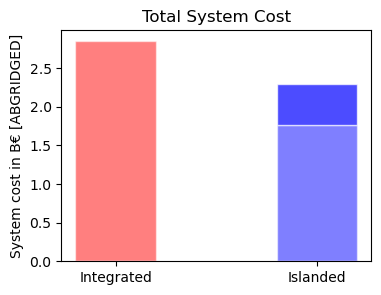

Costs for MAR ES only: [0, 1.767884566564331]
Costs for MAR ES + Export: [2.8473763347703858, 0]
Costs for Export only: [0, 0.5296598695480867]


In [92]:
n_names = ["Integrated", "Islanded"]
costs_mar_es_only = [0, n1.objective/1e9]
costs_mar_es_export = [n2.objective/1e9, 0]
costs_export_only = [0, n3.objective/1e9]

#bars = np.add(costs13, costs2).tolist()

# The position of the bars on the x-axis
r = [0,1]
barWidth = 0.4

# Create bars and stack them on previous bars
plt.figure(figsize=(4, 3))
plt.bar(r, costs_mar_es_only, alpha=0.5, color=['b'], edgecolor='white', width=barWidth)
plt.bar(r, costs_mar_es_export, alpha=0.5, color=['r'], edgecolor='white', width=barWidth)
plt.bar(r, costs_export_only, bottom=costs_mar_es_only, alpha=0.7, color=['b'], edgecolor='white', width=barWidth)

# enhance graph
plt.xticks(r, n_names)
plt.ylabel("System cost in B€ [ABGRIDGED]")
plt.title("Total System Cost")
#plt.ylim(212, 214)

# Show graphic
plt.savefig("../../results/graphics/first_results/total_system_cost.pdf", bbox_inches='tight')
plt.show()

# Print the costs costs_mar_es_only, costs_mar_es_export, costs_export_only
print(f"Costs for MAR ES only: {costs_mar_es_only}")
print(f"Costs for MAR ES + Export: {costs_mar_es_export}")
print(f"Costs for Export only: {costs_export_only}")


Maps

In [93]:
# Change the x and y value of the bus named "H2 export bus" to preselected location
n3.buses.loc[n3.buses.index == 'H2 export bus', 'x'] = -9.758585377234166
n3.buses.loc[n3.buses.index == 'H2 export bus', 'y'] = 34.50457835347685

In [94]:
n3.iplot(mapbox=True)

{'data': [Scattermapbox({
      'lat': [33.4634, 33.4634],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [-7.3913, -7.3913],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [32.79667142857143, 32.79667142857143],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [-6.740678571428572, -6.740678571428572],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [33.07327741935483, 33.07327741935483],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [-7.505829032258065, -7.505829032258065],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [34.69427142857143, 34.69427142857143],
      'line': {'color': 'darkseagreen', 'width': 3},
      'lon': [-2.515971428571429, -2.515971428571429],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [34.23870000000001, 34.23870000000001],
      'line': {'color': 'darkseagreen', 'width'

### Energy: Electrolysis output (n2 only, no comparison)

Capacities

In [95]:
# Total capacity Electrolysis. TODO very low -> SMR?
n2.links[n2.links.carrier.str.contains('H2 Electrolysis')].p_nom_opt.sum() /1e3 # in GW

4.205518870793567

In [96]:
# Total capacity SMR
n2.links[n2.links.carrier.str.contains('SMR')].p_nom_opt.sum() /1e3 # in GW

0.005946200508097168

In [97]:
# Total capacity Fischer-Tropsch    
n2.links[n2.links.carrier.str.contains('Fischer-Tropsch')].p_nom_opt.sum() /1e3 # in GW

9.226544468054033e-05

In [98]:
# Total power per hour SMR
n2.links_t.p1.loc[:, n2.links_t.p1.columns.str.contains("SMR")].sum(axis=1)

snapshot
2013-01-01   -4.364337
2013-01-07   -4.370829
2013-01-13   -4.366467
2013-01-19   -4.356739
2013-01-25   -4.354467
                ...   
2013-12-03   -4.329645
2013-12-09   -4.340483
2013-12-15   -4.331411
2013-12-21   -4.322861
2013-12-27   -4.294374
Length: 61, dtype: float64

Energies

In [99]:
# Total energy SMR
(n2.links_t.p1.loc[:, n2.links_t.p0.columns.str.contains("SMR")].sum(axis=1) * n2.snapshot_weightings.generators[0]).sum() / 1e6 # in TWh

-0.03350621169906184

In [100]:
# Total energy Fischer-Tropsch
(n2.links_t.p1.loc[:, n2.links_t.p0.columns.str.contains("Fischer-Tropsch")].sum(axis=1) * n2.snapshot_weightings.generators[0]).sum() / 1e6 # in TWh

-9.922368778306105e-05

### Demands (n2 only, no comparison)

In [101]:
n2.loads.carrier.unique() #.str.contains("H2")

array(['AC', 'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'gas for industry', 'H2 for industry', 'naphtha for industry',
       'industry oil emissions', 'low-temperature heat for industry',
       'industry electricity', 'process emissions', 'H2 for shipping',
       'shipping oil', 'shipping oil emissions', 'kerosene for aviation',
       'oil emissions', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions',
       'services electricity', 'agriculture electricity', 'H2'],
      dtype=object)

In [102]:
# Show hydrogen demand of n2 network
(n2.loads_t.p.loc[:, n2.loads_t.p.columns.str.contains("H2")].sum() *n2.snapshot_weightings.generators[0]).sum()/1e6 # in TWh


20.521670136986305

In [103]:
# For comparison: Show hydrogen demand of n1 network
(n1.loads_t.p.loc[:, n1.loads_t.p.columns.str.contains("H2")].sum() *n1.snapshot_weightings.generators[0]).sum()/1e6 # in TWh


0.4668756164383564

In [104]:
# Show highest consumers of n2 network
((n2.loads_t.p.sum()*n2.snapshot_weightings.generators[0]).sort_values(ascending=False)/1e6)[:10] # in TWh

Load
H2 export load                     20.054795
MAR.5.1_1                          10.258826
MAR.1.3_1                           7.176644
MAR.1.3_1 shipping oil              4.435318
MAR.1.3_1 kerosene for aviation     4.003563
MAR.2.1_1                           3.826578
MAR.9.5_1 land transport oil        3.797080
MAR.1.3_1 land transport oil        3.735616
MAR.5.1_1 land transport oil        2.933223
MAR.8.1_1 land transport oil        2.702631
dtype: float64

### Export

In [105]:
# Timeseries from export links
n2.links_t.p0.loc[:, n2.links_t.p0.columns.str.contains("export")].sum(axis=1)

snapshot
2013-01-01    2305.459508
2013-01-07    2305.503795
2013-01-13    2356.731069
2013-01-19    2198.115630
2013-01-25    2283.841304
                 ...     
2013-12-03    1317.959172
2013-12-09    1583.293047
2013-12-15    1334.591126
2013-12-21    1572.522217
2013-12-27    1625.385130
Length: 61, dtype: float64

In [106]:
# Total export per port
n2.links_t.p0.loc[:, n2.links_t.p0.columns.str.contains("export")].sum(axis=0)*n2.snapshot_weightings.generators[0]/1e6 # in TWh

Link
MAR.10.4_1 H2 export     0.000681
MAR.12.6_1 H2 export    20.036105
MAR.14.1_1 H2 export     0.000686
MAR.14.3_1 H2 export     0.000803
MAR.2.1_1 H2 export      0.000742
dtype: float64

In [107]:
# Timeseries export load
n2.loads_t.p.loc[:, n2.loads_t.p.columns.str.contains('export')]

Load,H2 export load
snapshot,
2013-01-01,2283.105023
2013-01-07,2283.105023
2013-01-13,2283.105023
2013-01-19,2283.105023
2013-01-25,2283.105023
...,...
2013-12-03,2283.105023
2013-12-09,2283.105023
2013-12-15,2283.105023


In [108]:
# Total export energy
print(f"The total export for n1 is {n1.loads_t.p.loc[:, n1.loads_t.p.columns.str.contains('export')].sum().values[0]*n2.snapshot_weightings.generators[0]:.2f} MWh")
print(f"The total export for n2 is {n2.loads_t.p.loc[:, n2.loads_t.p.columns.str.contains('export')].sum().values[0]*n2.snapshot_weightings.generators[0]:.2f} MWh")

The total export for n1 is 0.00 MWh
The total export for n2 is 20054794.52 MWh


In [109]:
print(f"The optimized energy capacity of the H2 export store is {n2.stores.e_nom_opt['H2 export store']/1e3:.2f} GWh")

The optimized energy capacity of the H2 export store is 1354.16 GWh


<AxesSubplot: xlabel='snapshot'>

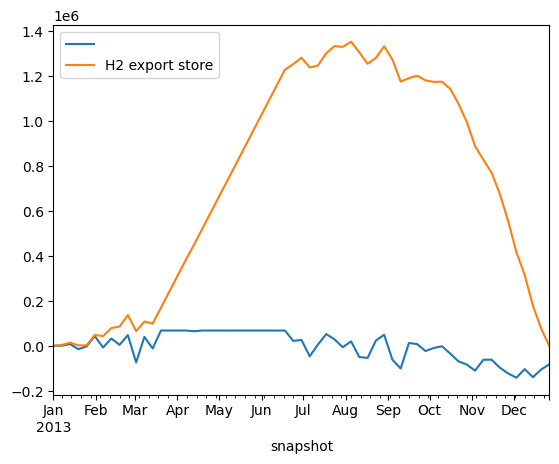

In [110]:
(-n2.stores_t.p['H2 export store'] * n2.snapshot_weightings.stores).plot(legend=True)
n2.stores_t.e['H2 export store'].plot(legend=True)